### Ray AI Runtime: An example for image classification

Ray AI Runtime (AIR) is a scalable and unified toolkit for ML applications. AIR enables simple scaling of individual workloads, end-to-end workflows, and popular ecosystem frameworks, all in just Python.
AIR builds on Ray’s best-in-class libraries for [Preprocessing](https://docs.ray.io/en/latest/data/dataset.html#datasets), [Training](https://docs.ray.io/en/latest/train/train.html#train-docs), [Tuning](https://docs.ray.io/en/latest/tune/index.html#tune-main), [Scoring](https://docs.ray.io/en/latest/ray-air/predictors.html#air-predictors), [Serving](https://docs.ray.io/en/latest/serve/index.html#rayserve), and [Reinforcement Learning](https://docs.ray.io/en/latest/rllib/index.html#rllib-index) to bring together an ecosystem of integrations. 

Out of the box with Ray AIR, you can easily build the common machine line pipeline with AIR's components.

<img src="images/air_ml_workflow.png" width="40%" height="20%">

This notebook employs each of these components to illustrate how in six distinct steps, using each of the Ray AIR [components and its APIs](https://docs.ray.io/en/latest/ray-air/package-ref.html#ray-air-api), to build a common ML pipeline for an image classification.


### The CIFAR-10 dataset for classification

The CIFAR-10 dataset consists of 60,000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.

Here are the classes in the dataset, as well as 10 random images from each:

<img src="images/cifar-10.png" width="30%" height="15%">

[Cifar-10 source](https://www.cs.toronto.edu/~kriz/cifar.html)

In [9]:
import ray

from ray import serve
from ray.serve import PredictorDeployment
from ray.data.datasource import SimpleTorchDatasource
import my_utils

from ray.train.torch import TorchTrainer

from ray.tune import Tuner
from ray.tune import TuneConfig
from ray.air.config import RunConfig
from ray.air.config import ScalingConfig
from ray.air.config import CheckpointConfig

from ray.train.torch import TorchPredictor
from ray.train.batch_predictor import BatchPredictor

import torch
import numpy as np
import pandas as pd
import requests

In [12]:
if ray.is_initialized():
    ray.shutdown()
ray.init()

2022-10-25 15:50:10,714	INFO worker.py:1518 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


RayContext(dashboard_url='127.0.0.1:8265', python_version='3.8.13', ray_version='3.0.0.dev0', ray_commit='{{RAY_COMMIT_SHA}}', address_info={'node_ip_address': '127.0.0.1', 'raylet_ip_address': '127.0.0.1', 'redis_address': None, 'object_store_address': '/tmp/ray/session_2022-10-25_15-50-08_790703_17148/sockets/plasma_store', 'raylet_socket_name': '/tmp/ray/session_2022-10-25_15-50-08_790703_17148/sockets/raylet', 'webui_url': '127.0.0.1:8265', 'session_dir': '/tmp/ray/session_2022-10-25_15-50-08_790703_17148', 'metrics_export_port': 62850, 'gcs_address': '127.0.0.1:63568', 'address': '127.0.0.1:63568', 'dashboard_agent_listen_port': 52365, 'node_id': '49b100ccc21d58fd4214109008dcce0d66036f603a7525102e09c622'})

In [13]:
ray.cluster_resources()

{'object_store_memory': 2147483648.0,
 'memory': 37388374836.0,
 'node:127.0.0.1': 1.0,
 'CPU': 10.0}

### Step 1. Fetch Data

Use Ray data to fetch data from a data source. Here we use a simple built-in `SimpleTorchDatasouce`. For preprocessing needs, such as scaling or normalizing, 
Ray AIR provides a host of preprocessors you can use; these [preprocessors](https://docs.ray.io/en/latest/ray-air/preprocessors.html) can be supplied downstream to `Trainers` and `BatchPredictors` to preprocess your 
input before training, tuning, or scoring, relieving you the onus of doing it yourself. 

<img src="images/data_prep.png" width="30%" height="15%">

In [11]:
train_dataset: ray.data.Dataset = ray.data.read_datasource(SimpleTorchDatasource(), dataset_factory=my_utils.train_dataset_factory)
test_dataset: ray.data.Dataset = ray.data.read_datasource(SimpleTorchDatasource(), dataset_factory=my_utils.test_dataset_factory)

2022-10-25 15:49:44,056	WARNING read_api.py:296 -- ⚠️  The number of blocks in this dataset (1) limits its parallelism to 1 concurrent tasks. This is much less than the number of available CPU slots in the cluster. Use `.repartition(n)` to increase the number of dataset blocks.
(_get_read_tasks pid=18450) 2022-10-25 15:49:44,054	WARNING torch_datasource.py:55 -- `SimpleTorchDatasource` doesn't support parallel reads. The `parallelism` argument will be ignored.


(_execute_read_task_nosplit pid=18450) Files already downloaded and verified


2022-10-25 15:49:49,503	WARNING read_api.py:296 -- ⚠️  The number of blocks in this dataset (1) limits its parallelism to 1 concurrent tasks. This is much less than the number of available CPU slots in the cluster. Use `.repartition(n)` to increase the number of dataset blocks.
(_get_read_tasks pid=18450) 2022-10-25 15:49:49,502	WARNING torch_datasource.py:55 -- `SimpleTorchDatasource` doesn't support parallel reads. The `parallelism` argument will be ignored.


(_execute_read_task_nosplit pid=18450) Files already downloaded and verified


In [7]:
train_dataset,test_dataset

(Dataset(num_blocks=1, num_rows=50000, schema=<class 'tuple'>),
 Dataset(num_blocks=1, num_rows=10000, schema=<class 'tuple'>))

### Step 2: Create a preprocessor to transform data
* Transform data into Pandas DataFrame because internally Ray data uses Pandas by default as it internal representation
* Use dataset `map_batches`() to convert 

In [ ]:
train_dataset = train_dataset.map_batches(my_utils.convert_batch_to_numpy)
test_dataset = test_dataset.map_batches(my_utils.convert_batch_to_numpy)

### Step 3: Create a `TorchTrainer` for PyTorch DDP training
This trainer is then fed into tuner for doing some hyper-parameter optimization. Ray AIR supports popular [Trainers](https://docs.ray.io/en/latest/ray-air/trainer.html)
for the common ML libraries: PyTorch, TensorFlow, XGBoost, scikit-learn. These can be used alongside [Tuner](https://docs.ray.io/en/latest/ray-air/tuner.html)

<img src="images/trainer.png" width="30%" height="15%">

In [6]:
trainer = TorchTrainer(train_loop_per_worker=my_utils.train_loop_per_worker,
    datasets={"train": train_dataset},
    scaling_config=ScalingConfig(num_workers=4, use_gpu=True),
)

### Step 4: Create the Tuner 

Tuning a model over a hyperparameters space is a common workload and paramount to get better accuracy. Here we tune the relevant tune configuration such as `lr`, `batch_size`, `epochs`.
However, you can use SOTA [search algorithms](https://docs.ray.io/en/latest/tune/api_docs/suggestion.html) and [schedulers](https://docs.ray.io/en/latest/tune/api_docs/schedulers.html) alongside [Tuner](https://docs.ray.io/en/latest/tune/api_docs/execution.html#ray.tune.Tuner) to control your trials, depending on your model requirements and desired results.


<img src="images/tuner.png" width="30%" height="15%">

In [7]:
tuner = Tuner(trainer,
        param_space={
            "train_loop_config": {
                "lr": ray.tune.grid_search([0.001, 0.01]),
            }
        },
        # specific tune metrics to collect and checkpoint
        # during trials
        tune_config=TuneConfig(metric="train_loss", mode="min"),
        run_config=RunConfig(checkpoint_config=CheckpointConfig(num_to_keep=1, 
                        checkpoint_score_attribute="train_loss", 
                        checkpoint_score_order="min")
        )
    )

Once we have set up our Trainer and Tuner, all we need to create distributed training and trials is use the 
familiar API .`.fit`() to launch our distributed trainiing and tuning.

In [8]:
# Run the tuner, which will calld trainer for each trial with
# the parameters configurations as part of it HPO and trains it in parallel
# with a shard of its own data. This is distributed training and tunning in parallel

results = tuner.fit()

(RayTrainWorker pid=31000) 2022-10-24 11:01:10,122	INFO config.py:87 -- Setting up process group for: env:// [rank=0, world_size=4]
(RayTrainWorker pid=5553, ip=172.31.13.42) 2022-10-24 11:01:13,204	INFO config.py:87 -- Setting up process group for: env:// [rank=0, world_size=4]
(RayTrainWorker pid=31000) 2022-10-24 11:01:14,247	INFO train_loop_utils.py:298 -- Moving model to device: cuda:3
(RayTrainWorker pid=5553, ip=172.31.13.42) 2022-10-24 11:01:15,867	INFO train_loop_utils.py:298 -- Moving model to device: cuda:2
(RayTrainWorker pid=31000) 2022-10-24 11:01:17,633	INFO train_loop_utils.py:362 -- Wrapping provided model in DistributedDataParallel.
(RayTrainWorker pid=5553, ip=172.31.13.42) 2022-10-24 11:01:19,196	INFO train_loop_utils.py:362 -- Wrapping provided model in DistributedDataParallel.


2022-10-24 11:01:38,548	WARNING util.py:244 -- The `process_trial_save` operation took 4.138 s, which may be a performance bottleneck.
2022-10-24 11:01:38,548	WARNING trial_runner.py:964 -- Consider turning off forced head-worker trial checkpoint syncs by setting sync_on_checkpoint=False. Note that this may result in faulty trial restoration if a failure occurs while the checkpoint is being synced from the worker to the head node.
2022-10-24 11:01:51,225	WARNING util.py:244 -- The `process_trial_save` operation took 2.415 s, which may be a performance bottleneck.
2022-10-24 11:02:05,301	WARNING util.py:244 -- The `process_trial_save` operation took 1.991 s, which may be a performance bottleneck.
2022-10-24 11:02:19,806	WARNING util.py:244 -- The `process_trial_save` operation took 1.937 s, which may be a performance bottleneck.
2022-10-24 11:02:35,084	WARNING util.py:244 -- The `process_trial_save` operation took 2.570 s, which may be a performance bottleneck.
2022-10-24 11:02:49,253	W

In [9]:
# Get the best checkpoint result
best_checkpoint = results.get_best_result(metric="train_loss", mode="min").checkpoint
best_checkpoint

TorchCheckpoint(local_path=/home/ray/ray_results/TorchTrainer_2022-10-24_11-01-01/TorchTrainer_d3915_00001_1_lr=0.0100_2022-10-24_11-01-07/checkpoint_000039)

In [10]:
best_checkpoint.to_directory("./best_checkpoint")

'best_checkpoint'

### Step 5: Use `TorchPredictor` using the `Checkpoint` object
This allows batch inference at scale:
* Test our model with [`TorchPredictor`](https://docs.ray.io/en/latest/_modules/ray/train/torch/torch_predictor.html?highlight=TorchPredictor) using the [`Checkpoint`](https://docs.ray.io/en/latest/ray-air/key-concepts.html#checkpoints) object.
* Fetch the best_checkpoint from the  checkpoint. 
* Use batch predictor to test the entire batch in one go


<img src="images/batch_predictor.png" width="30%" height="15%">

In [11]:
# drop the label column
predict_dataset = test_dataset.drop_columns(cols=["label"])

# Create our BatchPredictor from the best checkpoint obtained above after all the trials are finished
batch_predictor = BatchPredictor.from_checkpoint(
    checkpoint=best_checkpoint,
    predictor_cls=TorchPredictor,
    model=my_utils.ResNet18(),
    use_gpu=True
)

# Do prediction at scale over the entire batch
output: ray.data.Dataset = batch_predictor.predict(
    data=test_dataset, dtype=torch.float, 
    feature_columns=["image"], 
    keep_columns=["label"],
    num_gpus_per_worker=1,
)

Map Progress (1 actors 1 pending): 100%|██████████| 1/1 [00:10<00:00, 10.35s/it]


In [12]:
# Get the predictions from the output and convert them into classes
predictions = output.map_batches(my_utils.convert_logits_to_classes, batch_format="pandas")

# Get all predictions for test_dataset 
scores = predictions.map_batches(my_utils.calculate_prediction_scores)

# compute total prediction accuracy. That is all predictions equal to ground truth
# That is, predictated accurately.
total_acc = scores.sum(on="correct") / scores.count()

print(f"Prediction accuracy from the test data of 10,000 images: {total_acc * 100:.2f}%")

Shuffle Reduce: 100%|██████████| 1/1 [00:00<00:00, 125.29it/s]


Prediction accuracy from the test data of 10,000 images: 81.57%


### Step 6: Online prediction
 * Deploy our model to the network for online prediction
 * Use `TorchPredictor` and [`PredictorDeployment`](https://docs.ray.io/en/latest/ray-air/package-ref.html?highlight=PredictorDeployment#ray.serve.air_integrations.PredictorDeployment) APIs
 * Start a Ray serve in detached mode, with two replicas
 
 This will automatically deploy the model from the lastest checkpoint. You can adjust num of replicas in the options.
 
 <img src="images/online_predictor.png" width="30%" height="15%">
 

In [13]:
# Start Ray Serve in detached mode so that if this application terminates, Serve can still process the incoming
# requests. 
serve.start(detached=True)

# create the PredictorDeployment and give it a name and number of replicas. Depending on your
# request loads, you can scale up the number of replicas
deployment = PredictorDeployment.options(name="cifar-deployment", num_replicas=2)
deployment.deploy(TorchPredictor, best_checkpoint, batching_params=False, model=my_utils.ResNet18(), http_adapter=my_utils.json_to_numpy)

(ServeController pid=38039) INFO 2022-10-24 11:35:45,499 controller 38039 http_state.py:129 - Starting HTTP proxy with name 'SERVE_CONTROLLER_ACTOR:SERVE_PROXY_ACTOR-ec08616e8ea6b3796f36df7bcf2c557a99a712b51a430ff33812064d' on node 'ec08616e8ea6b3796f36df7bcf2c557a99a712b51a430ff33812064d' listening on '127.0.0.1:8000'
(HTTPProxyActor pid=38074) INFO:     Started server process [38074]
(ServeController pid=38039) INFO 2022-10-24 11:35:49,721 controller 38039 deployment_state.py:1310 - Adding 2 replicas to deployment 'cifar-deployment'.


### Test online prediction from the test data

(ServeReplica:cifar-deployment pid=7711, ip=172.31.13.42) INFO 2022-10-24 11:35:58,655 cifar-deployment cifar-deployment#qcnYXW replica.py:505 - HANDLE __call__ OK 0.4ms
(HTTPProxyActor pid=38074) INFO 2022-10-24 11:35:58,656 http_proxy 172.31.1.91 http_proxy.py:315 - POST /cifar-deployment 307 7.3ms
(HTTPProxyActor pid=38074) INFO 2022-10-24 11:35:58,782 http_proxy 172.31.1.91 http_proxy.py:315 - POST /cifar-deployment 200 124.0ms
(ServeReplica:cifar-deployment pid=38147) INFO 2022-10-24 11:35:58,781 cifar-deployment cifar-deployment#xPMkYS replica.py:505 - HANDLE __call__ OK 119.3ms


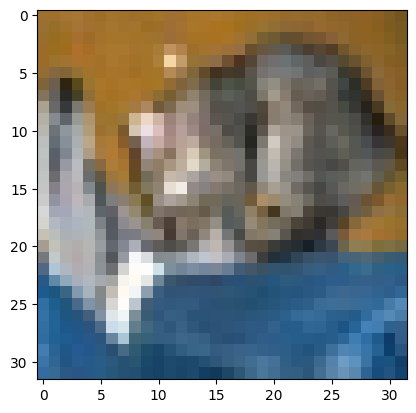

prediction: 3; class: cat; matched: True


(ServeReplica:cifar-deployment pid=7711, ip=172.31.13.42) INFO 2022-10-24 11:35:58,912 cifar-deployment cifar-deployment#qcnYXW replica.py:505 - HANDLE __call__ OK 0.3ms
(HTTPProxyActor pid=38074) INFO 2022-10-24 11:35:58,914 http_proxy 172.31.1.91 http_proxy.py:315 - POST /cifar-deployment 307 3.6ms
(HTTPProxyActor pid=38074) INFO 2022-10-24 11:35:58,945 http_proxy 172.31.1.91 http_proxy.py:315 - POST /cifar-deployment 200 29.7ms
(ServeReplica:cifar-deployment pid=38147) INFO 2022-10-24 11:35:58,944 cifar-deployment cifar-deployment#xPMkYS replica.py:505 - HANDLE __call__ OK 26.3ms


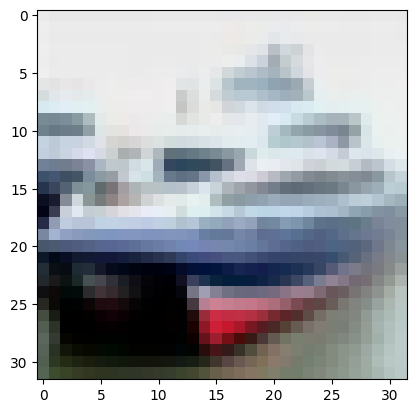

prediction: 8; class: ship; matched: True


(HTTPProxyActor pid=38074) INFO 2022-10-24 11:35:59,068 http_proxy 172.31.1.91 http_proxy.py:315 - POST /cifar-deployment 307 3.7ms
(ServeReplica:cifar-deployment pid=7711, ip=172.31.13.42) INFO 2022-10-24 11:35:59,067 cifar-deployment cifar-deployment#qcnYXW replica.py:505 - HANDLE __call__ OK 0.3ms
(HTTPProxyActor pid=38074) INFO 2022-10-24 11:35:59,099 http_proxy 172.31.1.91 http_proxy.py:315 - POST /cifar-deployment 200 28.8ms
(ServeReplica:cifar-deployment pid=38147) INFO 2022-10-24 11:35:59,097 cifar-deployment cifar-deployment#xPMkYS replica.py:505 - HANDLE __call__ OK 25.5ms


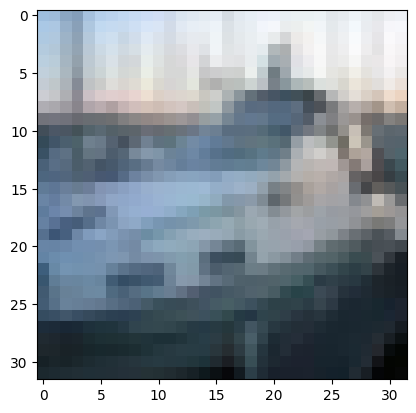

prediction: 8; class: ship; matched: True


(ServeReplica:cifar-deployment pid=7711, ip=172.31.13.42) INFO 2022-10-24 11:35:59,216 cifar-deployment cifar-deployment#qcnYXW replica.py:505 - HANDLE __call__ OK 0.2ms
(HTTPProxyActor pid=38074) INFO 2022-10-24 11:35:59,218 http_proxy 172.31.1.91 http_proxy.py:315 - POST /cifar-deployment 307 3.1ms
(HTTPProxyActor pid=38074) INFO 2022-10-24 11:35:59,247 http_proxy 172.31.1.91 http_proxy.py:315 - POST /cifar-deployment 200 28.1ms
(ServeReplica:cifar-deployment pid=38147) INFO 2022-10-24 11:35:59,246 cifar-deployment cifar-deployment#xPMkYS replica.py:505 - HANDLE __call__ OK 25.0ms


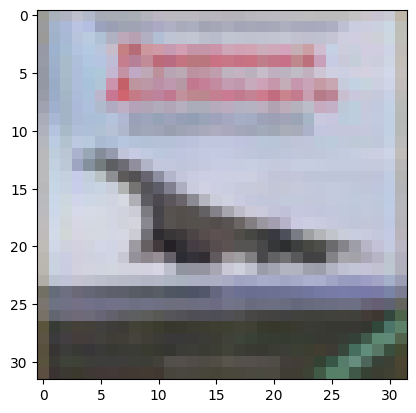

prediction: 0; class: plane; matched: True


(HTTPProxyActor pid=38074) INFO 2022-10-24 11:35:59,382 http_proxy 172.31.1.91 http_proxy.py:315 - POST /cifar-deployment 307 3.5ms
(ServeReplica:cifar-deployment pid=7711, ip=172.31.13.42) INFO 2022-10-24 11:35:59,381 cifar-deployment cifar-deployment#qcnYXW replica.py:505 - HANDLE __call__ OK 0.3ms
(HTTPProxyActor pid=38074) INFO 2022-10-24 11:35:59,414 http_proxy 172.31.1.91 http_proxy.py:315 - POST /cifar-deployment 200 30.0ms
(ServeReplica:cifar-deployment pid=38147) INFO 2022-10-24 11:35:59,412 cifar-deployment cifar-deployment#xPMkYS replica.py:505 - HANDLE __call__ OK 26.2ms


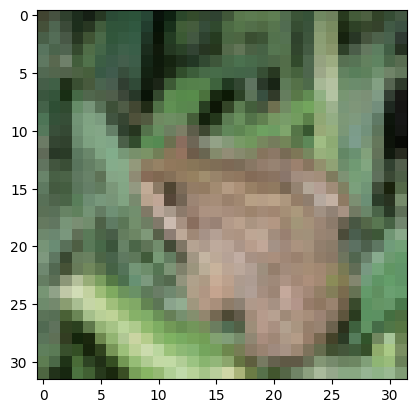

prediction: 6; class: frog; matched: True


(ServeReplica:cifar-deployment pid=7711, ip=172.31.13.42) INFO 2022-10-24 11:35:59,551 cifar-deployment cifar-deployment#qcnYXW replica.py:505 - HANDLE __call__ OK 0.3ms
(HTTPProxyActor pid=38074) INFO 2022-10-24 11:35:59,553 http_proxy 172.31.1.91 http_proxy.py:315 - POST /cifar-deployment 307 3.8ms
(HTTPProxyActor pid=38074) INFO 2022-10-24 11:35:59,600 http_proxy 172.31.1.91 http_proxy.py:315 - POST /cifar-deployment 200 45.0ms
(ServeReplica:cifar-deployment pid=38147) INFO 2022-10-24 11:35:59,598 cifar-deployment cifar-deployment#xPMkYS replica.py:505 - HANDLE __call__ OK 41.4ms


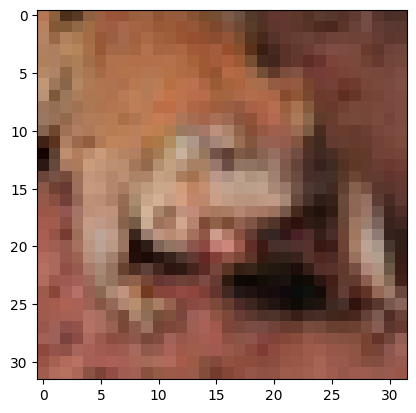

prediction: 6; class: frog; matched: True


(ServeReplica:cifar-deployment pid=7711, ip=172.31.13.42) INFO 2022-10-24 11:35:59,734 cifar-deployment cifar-deployment#qcnYXW replica.py:505 - HANDLE __call__ OK 0.3ms
(HTTPProxyActor pid=38074) INFO 2022-10-24 11:35:59,735 http_proxy 172.31.1.91 http_proxy.py:315 - POST /cifar-deployment 307 4.3ms
(HTTPProxyActor pid=38074) INFO 2022-10-24 11:35:59,767 http_proxy 172.31.1.91 http_proxy.py:315 - POST /cifar-deployment 200 30.0ms
(ServeReplica:cifar-deployment pid=38147) INFO 2022-10-24 11:35:59,765 cifar-deployment cifar-deployment#xPMkYS replica.py:505 - HANDLE __call__ OK 26.5ms


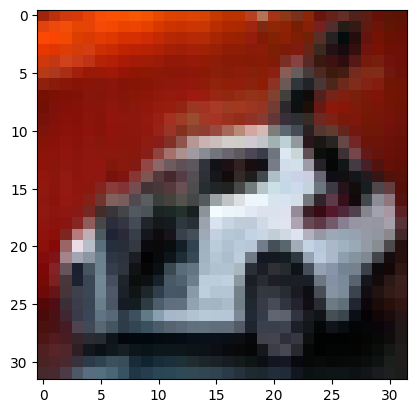

prediction: 1; class: car; matched: True


(HTTPProxyActor pid=38074) INFO 2022-10-24 11:35:59,900 http_proxy 172.31.1.91 http_proxy.py:315 - POST /cifar-deployment 307 3.4ms
(ServeReplica:cifar-deployment pid=7711, ip=172.31.13.42) INFO 2022-10-24 11:35:59,899 cifar-deployment cifar-deployment#qcnYXW replica.py:505 - HANDLE __call__ OK 0.2ms
(HTTPProxyActor pid=38074) INFO 2022-10-24 11:35:59,931 http_proxy 172.31.1.91 http_proxy.py:315 - POST /cifar-deployment 200 28.8ms
(ServeReplica:cifar-deployment pid=38147) INFO 2022-10-24 11:35:59,929 cifar-deployment cifar-deployment#xPMkYS replica.py:505 - HANDLE __call__ OK 25.6ms


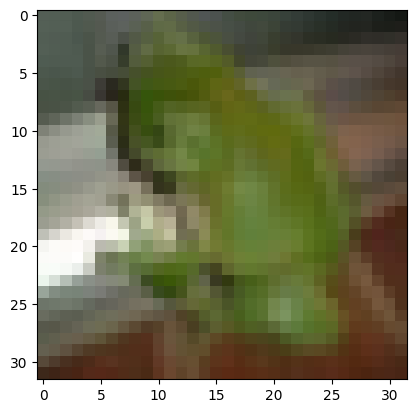

prediction: 6; class: frog; matched: True


(ServeReplica:cifar-deployment pid=7711, ip=172.31.13.42) INFO 2022-10-24 11:36:00,055 cifar-deployment cifar-deployment#qcnYXW replica.py:505 - HANDLE __call__ OK 0.2ms
(HTTPProxyActor pid=38074) INFO 2022-10-24 11:36:00,057 http_proxy 172.31.1.91 http_proxy.py:315 - POST /cifar-deployment 307 4.0ms
(HTTPProxyActor pid=38074) INFO 2022-10-24 11:36:00,097 http_proxy 172.31.1.91 http_proxy.py:315 - POST /cifar-deployment 200 38.5ms
(ServeReplica:cifar-deployment pid=38147) INFO 2022-10-24 11:36:00,096 cifar-deployment cifar-deployment#xPMkYS replica.py:505 - HANDLE __call__ OK 35.2ms


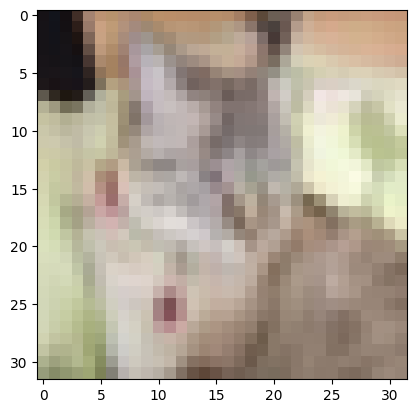

prediction: 3; class: cat; matched: True


(HTTPProxyActor pid=38074) INFO 2022-10-24 11:36:00,236 http_proxy 172.31.1.91 http_proxy.py:315 - POST /cifar-deployment 307 3.6ms
(ServeReplica:cifar-deployment pid=7711, ip=172.31.13.42) INFO 2022-10-24 11:36:00,235 cifar-deployment cifar-deployment#qcnYXW replica.py:505 - HANDLE __call__ OK 0.2ms
(HTTPProxyActor pid=38074) INFO 2022-10-24 11:36:00,277 http_proxy 172.31.1.91 http_proxy.py:315 - POST /cifar-deployment 200 39.6ms
(ServeReplica:cifar-deployment pid=38147) INFO 2022-10-24 11:36:00,276 cifar-deployment cifar-deployment#xPMkYS replica.py:505 - HANDLE __call__ OK 36.2ms


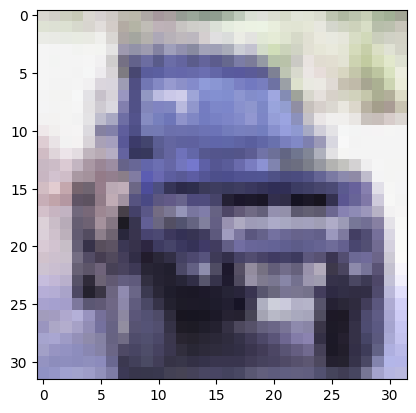

prediction: 1; class: car; matched: True


In [14]:
# Test online deployment
batch = test_dataset.take(10)
for i in range(10):
    array = np.expand_dims(np.array(batch[i]["image"]), axis=0)
    label = np.array(batch[i]["label"])
    # send request and fetch prediction
    payload  = {"array": array.tolist()}
    response = requests.post(deployment.url, json=payload)
    result = response.json()[0]
    idx, cls = my_utils.to_prediction_cls(result)
    matched = idx == label
    my_utils.img_show(batch[i]["image"])
    print(f"prediction: {idx}; class: {cls}; matched: {matched}")

In [18]:
# Shutdown our server
serve.shutdown()

(ServeController pid=85106) INFO 2022-10-12 10:43:27,798 controller 85106 deployment_state.py:1336 - Removing 2 replicas from deployment 'cifar-deployment'.


### Exercises

 * Try scaling your Trainer and Tunner
  * increase the `num_workers` to 3 or 4
  * extend the tuning space 
    * `epochs=[75, 100, 125]`
    * `batch_size=[32, 64]`

### Extra-curriculam and Resources

Here some extra reading and resources for you:
 * Watch the Ray Summit 2022 on [Introduction to Ray AIR](https://www.anyscale.com/ray-summit-2022/agenda/sessions/226)
 * Ray AIR [documentation](https://docs.ray.io/en/latest/ray-air/getting-started.html)
 * Understand its [Components and APIs](https://docs.ray.io/en/latest/ray-air/package-ref.html)
 * Ray AIR [user guides](https://docs.ray.io/en/latest/ray-air/user-guides.html) and examples](https://docs.ray.io/en/latest/ray-air/examples/index.html) 